In [1]:
import numpy as np
import astropy.units as u
import yaml
import utils
import matplotlib.pyplot as plt

from gammapy.data import DataStore
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.datasets import MapDataset
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.modeling.models import FoVBackgroundModel, Models
from gammapy.modeling import Fit
from gammapy.irf import Background3D

import warnings
warnings.filterwarnings('ignore')

In [88]:
# loading general parameters
with open("../general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']
bdt_edges=cfg['bdt_edges']

hessera = 'hess1'
muoneff_flag= cfg['muoneff_flag']
muoneff_flag=True
unit_list = ['deviation [std]', 'deviation [% of bkg]']

In [9]:
# defining the geometry for the datasets
energy_bins = np.logspace(-1, 2, cfg['N_ebins']+1)
axis = MapAxis.from_edges(energy_bins, unit="TeV", name="energy", interp="log")
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(methods=['offset-max', 'bkg-peak'], offset_max=cfg['offset_cut'] * u.deg)

In [10]:
runlist = [18415, 80170]
muoneff_path = f'{cfg["muoneff_path"]}/{hessera}/hess1_hess2/v01c_kaori_mueff'

basedir = f'{cfg["FITS_PROD"]}/{hessera}/std_{conf}_fullEnclosure'
ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
table = ds.obs_table
observations = ds.get_observations(runlist)

No HDU found matching: OBS_ID = 18415, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 80170, HDU_TYPE = rad_max, HDU_CLASS = None


In [11]:
dataset_list = []
for obs in observations:
    # taking care of the correct bkg model (if it is muoneff or official model)
    # the official model is stored in the fits tables. For the muoneff model, we will just change the path of the bkg model
    if muoneff_flag:
        if obs.obs_info['MUONEFF'] > 0.085:
            model_CD = 'B'
        elif obs.obs_info['MUONEFF'] >= 0.075:
            model_CD = 'D'
        else:
            model_CD = 'C'

        if obs.obs_id >= 100000:
            run_number= f'{obs.obs_id}'
        else:
            run_number= f'0{obs.obs_id}'
        filename = f'{muoneff_path}_{model_CD}/hess_bkg_3d_v01c_kaori_mueff_{model_CD}_norebin_fov_radec_{run_number}.fits.gz'
        obs.bkg = Background3D.read(filename, hdu='BACKGROUND')

    geom = WcsGeom.create(skydir=obs.pointing_radec, binsz=cfg['binsz'], width=cfg['width']* u.deg, frame="icrs", axes=[axis])        
    dataset = MapDataset.create(geom=geom)
    dataset = maker.run(dataset, obs)
    dataset = maker_safe_mask.run(dataset, obs)

    # create here mask_fit
    dataset.mask_fit = Map.from_geom(geom=geom, data=np.ones_like(dataset.counts.data).astype(bool))
    coord = utils.get_mask_fov(obs.pointing_radec.ra.deg, obs.pointing_radec.dec.deg, 5)
    if coord != 0: #this means that if there are regions to be masked
        for s in coord:
            dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"icrs;circle({s[0]}, {s[1]}, {s[2]})")
            
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    dataset.models = Models([bkg_model])
    dataset.background_model.spectral_model.tilt.frozen = False

    Fit().run(datasets=[dataset])

    dataset_list.append(dataset)

Missing 'HDUCLAS2' keyword assuming 'BKG'
Missing 'HDUCLAS2' keyword assuming 'BKG'


In [19]:
x_axis= dataset.counts.geom.axes['energy'].center.value

fig, ax = plt.subplots(1,4, figsize=(25, 5))

ax[0].set_title('COUNTS, sum over energy axis')
ax[1].set_title('BKG AFTER FIT, sum over energy axis')

for i in range(2):
    ax[i].set_xlabel('ra [arb.u.]')
    ax[i].set_ylabel('dec [arb.u.]')

(dataset.counts.smooth(5)*dataset.mask_fit).sum_over_axes().plot(add_cbar=True, ax=ax[0])
(dataset.npred().smooth(1)*dataset.mask_fit).sum_over_axes().plot(add_cbar=True, ax=ax[1])

c = np.nansum((dataset.counts * dataset.mask_fit *dataset.mask_safe).data, axis=(1, 2))
b = np.nansum((dataset.npred() * dataset.mask_fit *dataset.mask_safe).data, axis=(1, 2))
error = (c-b)/np.sqrt(b)

ax[2].plot(x_axis, c, label='counts')
ax[2].plot(x_axis, b, label='bkg after fit', ls='--')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].legend()
ax[2].set_xlabel('energy [TeV]')
ax[2].set_ylabel('counts')
ax[2].set_title('SPECTRUM, sum over spatial axes')

ax[3].plot(x_axis, error, color='gray')
ax[3].set_xlabel('energy [TeV]')
ax[3].set_ylabel('(data-model)/sqrt(model)')
ax[3].axhline(0, color='yellow')
ax[3].set_xscale('log')
ax[3].set_title('DEVIATION, sum over spatial axes')

plt.suptitle(f'obsid={obs.obs_id}', size=20)
plt.savefig('1.png')

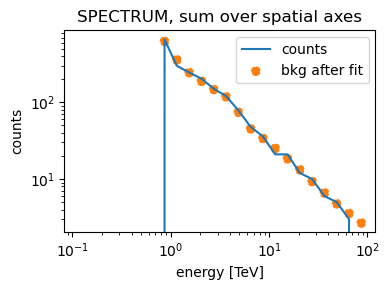

In [35]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

ax.plot(x_axis, c, label='counts')
ax.scatter(x_axis, b, label='bkg after fit', ls='--', color='C1')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('energy [TeV]')
ax.set_ylabel('counts')
ax.set_title('SPECTRUM, sum over spatial axes')
plt.tight_layout()
plt.savefig('2.png')

In [101]:
pwd

'/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/0-plots_for_confluencepage'

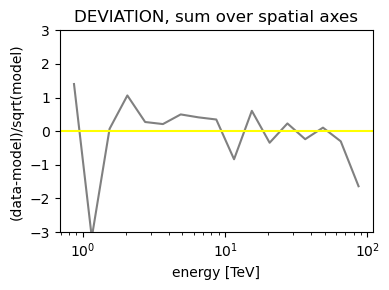

In [49]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)
ax.plot(x_axis, error, color='gray')
ax.set_xlabel('energy [TeV]')
ax.set_ylabel('(data-model)/sqrt(model)')
ax.axhline(0, color='yellow')
ax.set_ylim(-3,3)
ax.set_xscale('log')
ax.set_title('DEVIATION, sum over spatial axes')
plt.tight_layout()
plt.savefig('3.png')

In [36]:
with open("../general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']
N_ebins = cfg['N_ebins']
zen_bins = cfg['zen_bins']
hesseras= ['hess1', 'hess2']
muoneff_flag= cfg['muoneff_flag']
bdt_edges = cfg['bdt_edges']

if muoneff_flag == False:
    print('ATTENTION, THIS SCRIPT IS MADE FOR BKG MODEL WITH MUONEFF BINNING')

model_str = cfg['model_str']
energy_bins = np.logspace(-1, 2, N_ebins+1)

if N_ebins==24:
    e_center= [0.1154782 ,  0.15399265,  0.2053525 ,  0.27384197,  0.36517413,
            0.48696753,  0.64938163,  0.86596432,  1.15478201,  1.53992656,
            2.05352501,  2.73841962,  3.65174137,  4.86967527,  6.49381614,
            8.65964312, 11.54781997, 15.3992658 , 20.53525094, 27.38419634,
           36.51741269, 48.6967522 , 64.93816094, 86.59643066]

In [40]:
# general options for the error estimation

# muoneff_flag is related if the user wants to calculate the error estimation for the bkg model with muoneff bins
# edisp is related to the energy threshold applied during the analysis

def call_analysis_type(analysis_type='alternative'):
    if analysis_type == 'standard':
        edisp, muoneff_flag = True, False # standard analysis
    else:
        edisp, muoneff_flag = False, True # increasing the statistics
    return edisp, muoneff_flag

In [38]:
# functions for plotting and saving 

def plot_mean_std(N_est, er_est, std_est):
    for unit in range(2): 
        fig, ax = plt.subplots(3, 7, figsize=(3*12,12))
        for zen in range(7):
            for model in range(3):
                N = N_est[zen, model]
                mean =er_est[zen, model, unit]
                std= std_est[zen, model, unit]
                ax[model][zen].plot(e_center, mean, label='mean')
                ax[model][zen].axhline(0, color='C0', alpha=0.5, ls=':', label='ideal mean')
                ax[model][zen].fill_between(e_center, mean-3/np.sqrt(N), mean+3/np.sqrt(N), color='lightyellow', label='statistical 3 sigma')
                ax[model][zen].plot(e_center, std, label='std')
                ax[model][zen].fill_between(e_center, std-3/np.sqrt(N), std+3/np.sqrt(N), color='lightyellow')
                ax[model][zen].axhline(1, color='C1', alpha=0.5, ls=':', label='ideal std')
                ax[model][zen].set_xscale('log')
                if unit ==0:
                    ax[model][zen].set_ylim(-7,7)
                else:
                    ax[model][zen].set_ylim(-20,20)

                ax[model][zen].legend()
                if model == 0:
                    ax[model][zen].set_title(f'zen={zen_bins[zen]}-{zen_bins[zen+1]}')
                if zen == 0:
                    ax[model][zen].set_ylabel(unit_list[unit])
                if model == 2:
                    ax[model][zen].set_xlabel(f'energy [TeV]')

        plt.show()
        
def plot_lookup_table(er_est):
    xv, yv = np.meshgrid(zen_bins, energy_bins, indexing='ij')
    fig, ax = plt.subplots(2, 1, dpi=120, figsize=(4,7))
    
    for i in range(2):
        Z = np.zeros((len(zen_bins),len(energy_bins)))
        for zen in range(len(zen_bins)-1):
            for e in range(len(energy_bins)-1):
                Z[zen][e] = er_est[zen, 2, i, e]

        c = ax[i].pcolor(yv, xv, Z, cmap='plasma', vmax=1, vmin=-1)
        fig.colorbar(c, ax=ax[i], label=unit_list[i])
        for zen in zen_bins:
            ax[i].axhline(zen, color='lightgray')
        for e in energy_bins:
            ax[i].axvline(e, color='lightgray')


        ax[i].set_xscale('log')
        ax[i].set_xlabel('Energy [TeV]')
        ax[i].set_ylabel('zenith')
    plt.show()

In [44]:
# functions for estimating the result

def get_results(hessera, edisp, muoneff_flag):
    
    basedir = f'$FITS_PROD/{hessera}/std_{conf}_fullEnclosure'
    ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
    table = ds.obs_table
    
    # load results
    if hessera == 'hess1':
        idx_max = 37
    elif hessera == 'hess2':
        idx_max = 7
    for idx in range(idx_max):
        if edisp==True and muoneff_flag==False:
            file_path = f'../1-error_estimation/results/dataspectrum_edisp_NOmuoneff'
        elif edisp==True and muoneff_flag==True:
            file_path = f'../1-error_estimation/results/dataspectrum_edisp_muoneff'
        elif edisp==False and muoneff_flag==True:
            file_path = f'../1-error_estimation/results/dataspectrum_muoneff'            
        
        if idx==0:
            file = np.loadtxt(f'{file_path}_{hessera}_part{idx}.txt')
        else:
            file = np.concatenate((file, np.loadtxt(f'{file_path}_{hessera}_part{idx}.txt')))
    obsid_list = file[:, 0].astype(int)
    obsid_list_original = np.loadtxt(f'../1-error_estimation/initial_runlist_{hessera}.txt').astype(int)
    print(f'there are {len(obsid_list_original)-len(obsid_list)}/{len(obsid_list_original)} with problems')

    # getting the error per run in units of statistical standard deviation and in units of bkg percentage
    counts=file[:, 1:N_ebins+1]
    background = file[:, N_ebins+1:]
    error_std = (counts - background)/np.sqrt(background)
    error_percentage = 100*(counts - background)/background

    #getting information of zenith and model of each run (these are the bins for error estimation)
    info = []
    for obs in obsid_list:
        idx = np.where(table['OBS_ID']==obs)[0][0]
        zen_pnt = table['ZEN_PNT'][idx]
        zen_bin = np.sum(zen_pnt > zen_bins) - 1

        if muoneff_flag==True:
#        if 1==1:
            muoneff = table['MUONEFF'][idx]
            if muoneff > 0.085:
                model = 0 #'B'
            elif muoneff >= 0.075:
                    model = 1 # 'D'
            else:
                model = 2 #'C'
        else:
            model=2

        info.append([obs, zen_pnt, zen_bin, model])
    info= np.asarray(info)

    return info, error_std, error_percentage
    
def calculate_error(info, error_std, error_percentage):
    
    def plot(res, model, zen, ax_idx):
        ax[ax_idx][zen].plot(e_center, res.T, color='lightgray');
        ax[ax_idx][zen].plot(e_center, (res)[0], color='lightgray', label='1 run');
        ax[ax_idx][zen].plot(e_center, np.nanmean(res.T, axis=1), color='black', label=f'mean over\nN_runs={np.sum(mask)}');
        ax[ax_idx][zen].set_xscale('log')
        ax[ax_idx][zen].legend(loc='lower right')
        if ax_idx < 3:
            ax[ax_idx][zen].set_ylim(-10,10)
            if zen==0:
                ax[ax_idx][zen].set_ylabel(f'error [std]')
        else:
            ax[ax_idx][zen].set_ylim(-50,50)
            if zen==0:
                ax[ax_idx][zen].set_ylabel(f'error [bkg %]')
            

    # 7 corresponds to zen bins, 3 to 
    N_est = np.ndarray((7, 3, 1), dtype=int)
    er_est = np.ndarray((7, 3, 2, 24)) #error for 7 zenbins, 3 bkg models, 2 units of error std and percentage, 24 energy bins 
    std_est = np.ndarray((7, 3, 2, 24)) # here is the std of the error
    
    fig, ax = plt.subplots(6, 7, figsize=(3*12,24))
    for zen in range(7):
        for model in range(3):
            mask_zen = info.T[2] == zen
            mask_model = info.T[3] == model
            mask = mask_zen & mask_model
            N_est[zen][model][0] = np.sum(mask)
            
            if np.sum(mask) == 0:
                print(f'no runs for zen={zen}, model={model_str[model]}')
            else: 
                mean_value = np.nanmean(error_std[mask].T, axis=1)
                mean_value = [mean_value[ii] if abs(mean_value[ii]) > 5/np.sqrt(np.sum(mask)) else 0 for ii in range(N_ebins)]
                mean_value_per = np.nanmean(error_percentage[mask].T, axis=1)
                mean_value_per = [mean_value_per[ii] if abs(mean_value[ii]) > 5/np.sqrt(np.sum(mask)) else 0 for ii in range(N_ebins)]
                
                er_est[zen][model][0] = mean_value
                er_est[zen][model][1] = mean_value_per
                std_est[zen][model][0] = np.nanstd(error_std[mask].T, axis=1)
                std_est[zen][model][1] = np.nanstd(error_percentage[mask].T, axis=1)
                
                plot(error_std[mask], model, zen, model)
                plot(error_percentage[mask], model, zen, model+3)

                er_est[zen][model][0] = np.nanmean(error_std[mask].T, axis=1)
                er_est[zen][model][1] = np.nanmean(error_percentage[mask].T, axis=1)
                std_est[zen][model][0] = np.nanstd(error_std[mask].T, axis=1)
                std_est[zen][model][1] = np.nanstd(error_percentage[mask].T, axis=1)
                
                plot(error_std[mask], model, zen, model)
                plot(error_percentage[mask], model, zen, model+3)
                
    #########################################
    ## setting some features of the systematic errors by hand:
    
    ## setting the systematic for the zen 0-15, model B, from energy bin 15, to 0 because there the model construction does not have enough statistics and therefore the systematic estimation is wrong
    ## the motivation to 0 is because there is no enough statistics, and therefore setting to 0 is good
    er_est[0,0,:, 15:]=0

    # i also set to above 30 TeV systematic to 0
    # due to the lack of statistics in the model construction (not the lack of runs, but the lack of data in these runs)
    for zen in range(7):
        for model in range(3):
            er_est[zen,model,:, 20:]=0
            
    return N_est, er_est, std_est

there are 0/7260 with problems
no runs for zen=0, model=B
no runs for zen=0, model=D
no runs for zen=1, model=B
no runs for zen=1, model=D
no runs for zen=2, model=B
no runs for zen=2, model=D
no runs for zen=3, model=B
no runs for zen=3, model=D
no runs for zen=4, model=B
no runs for zen=4, model=D
no runs for zen=5, model=B
no runs for zen=5, model=D
no runs for zen=6, model=B
no runs for zen=6, model=D


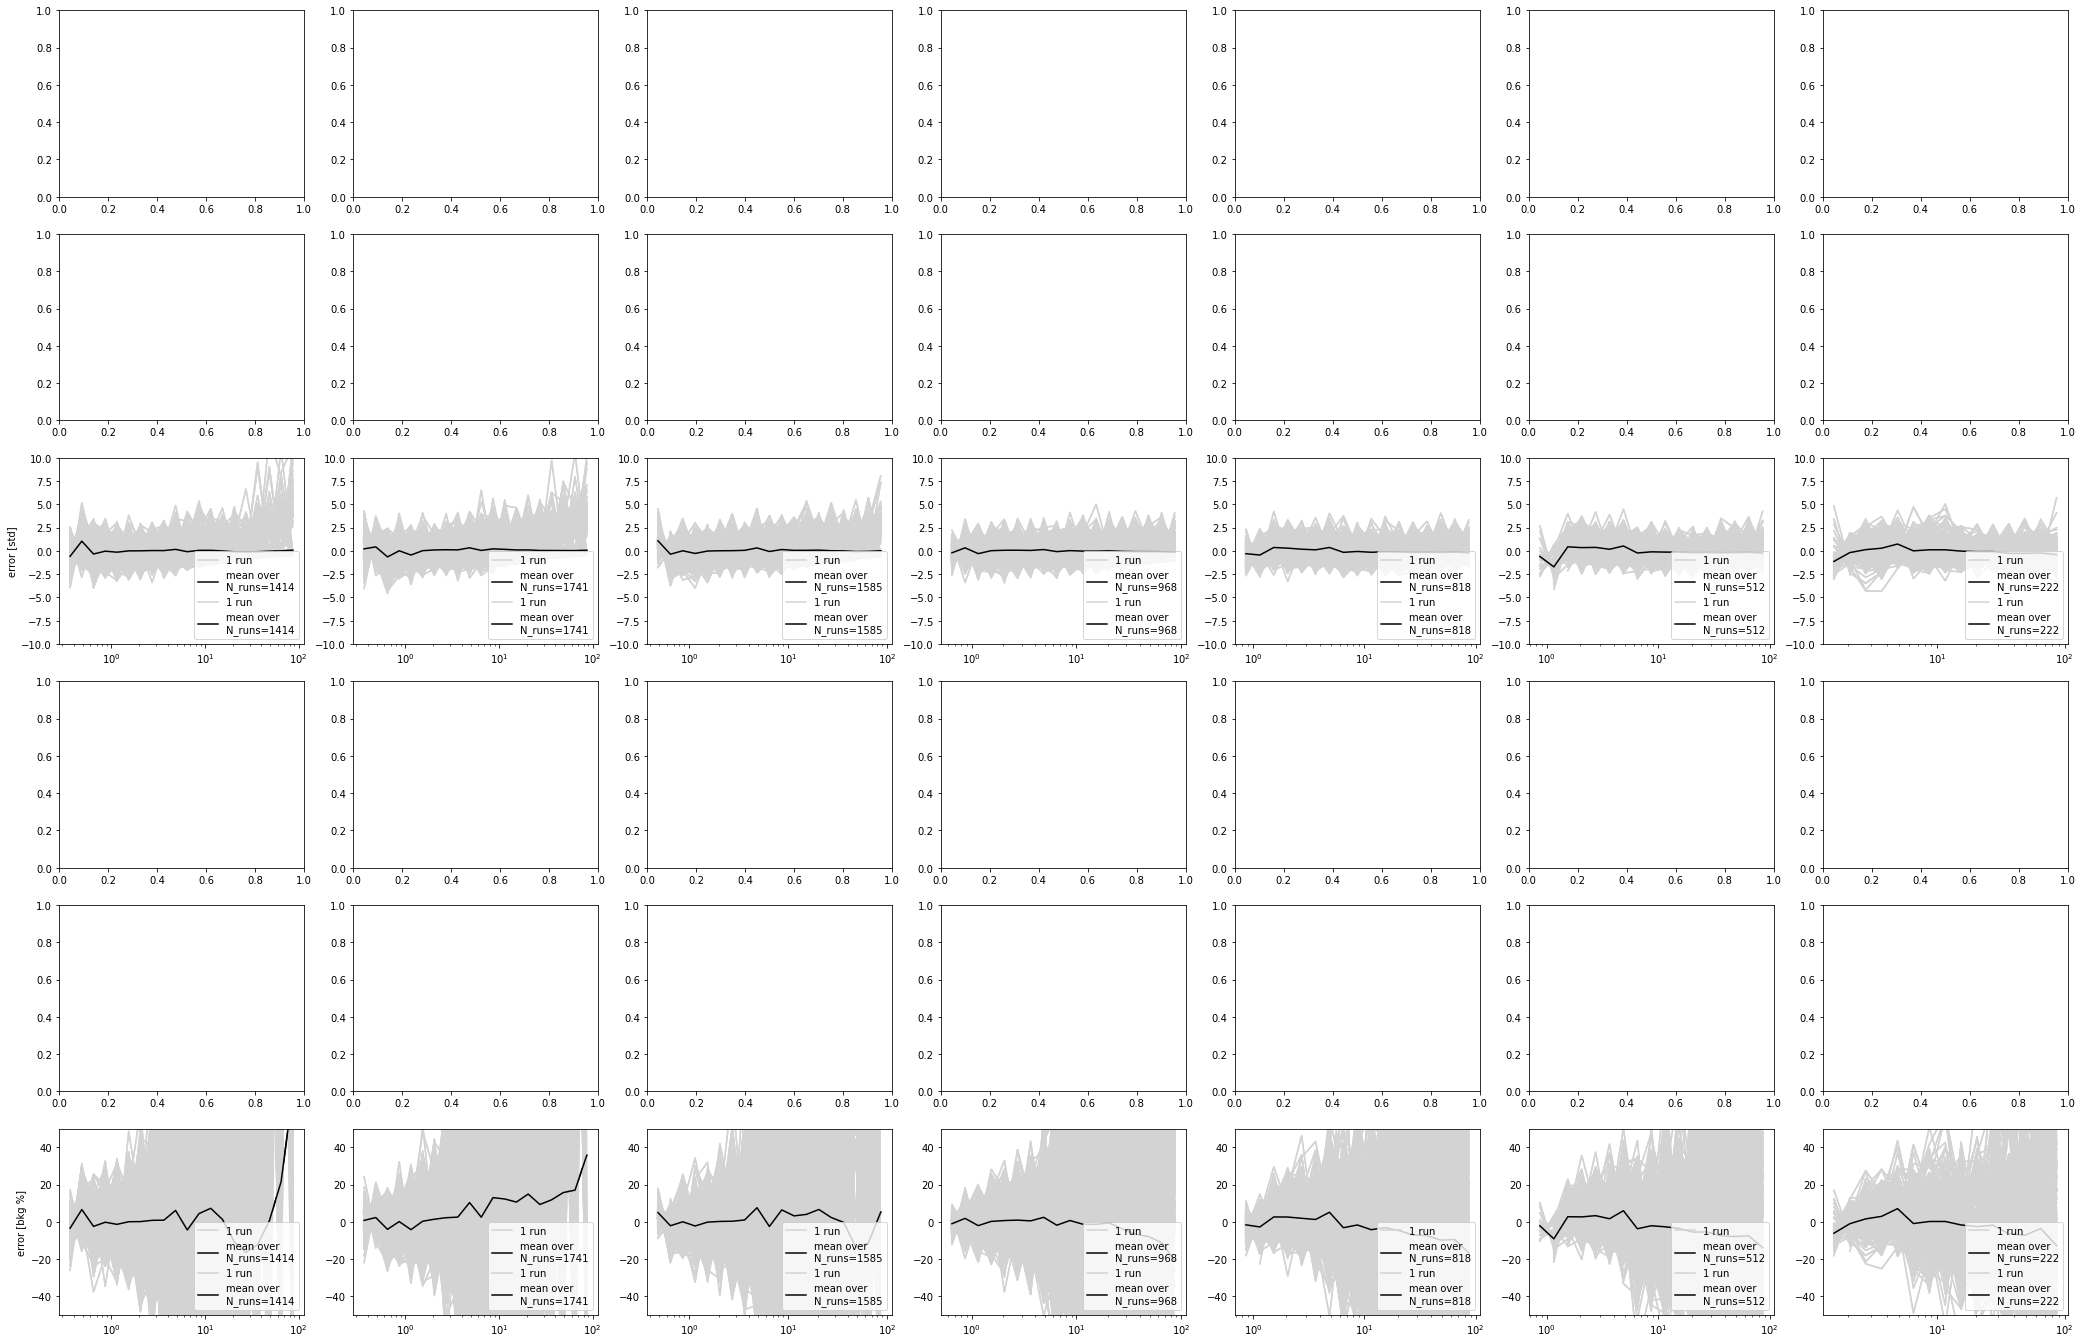

In [45]:
hessera = 'hess1'

edisp, muoneff_flag = call_analysis_type('standard')
info, error_std, error_percentage = get_results(hessera, edisp, muoneff_flag)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)

there are 1/7260 with problems


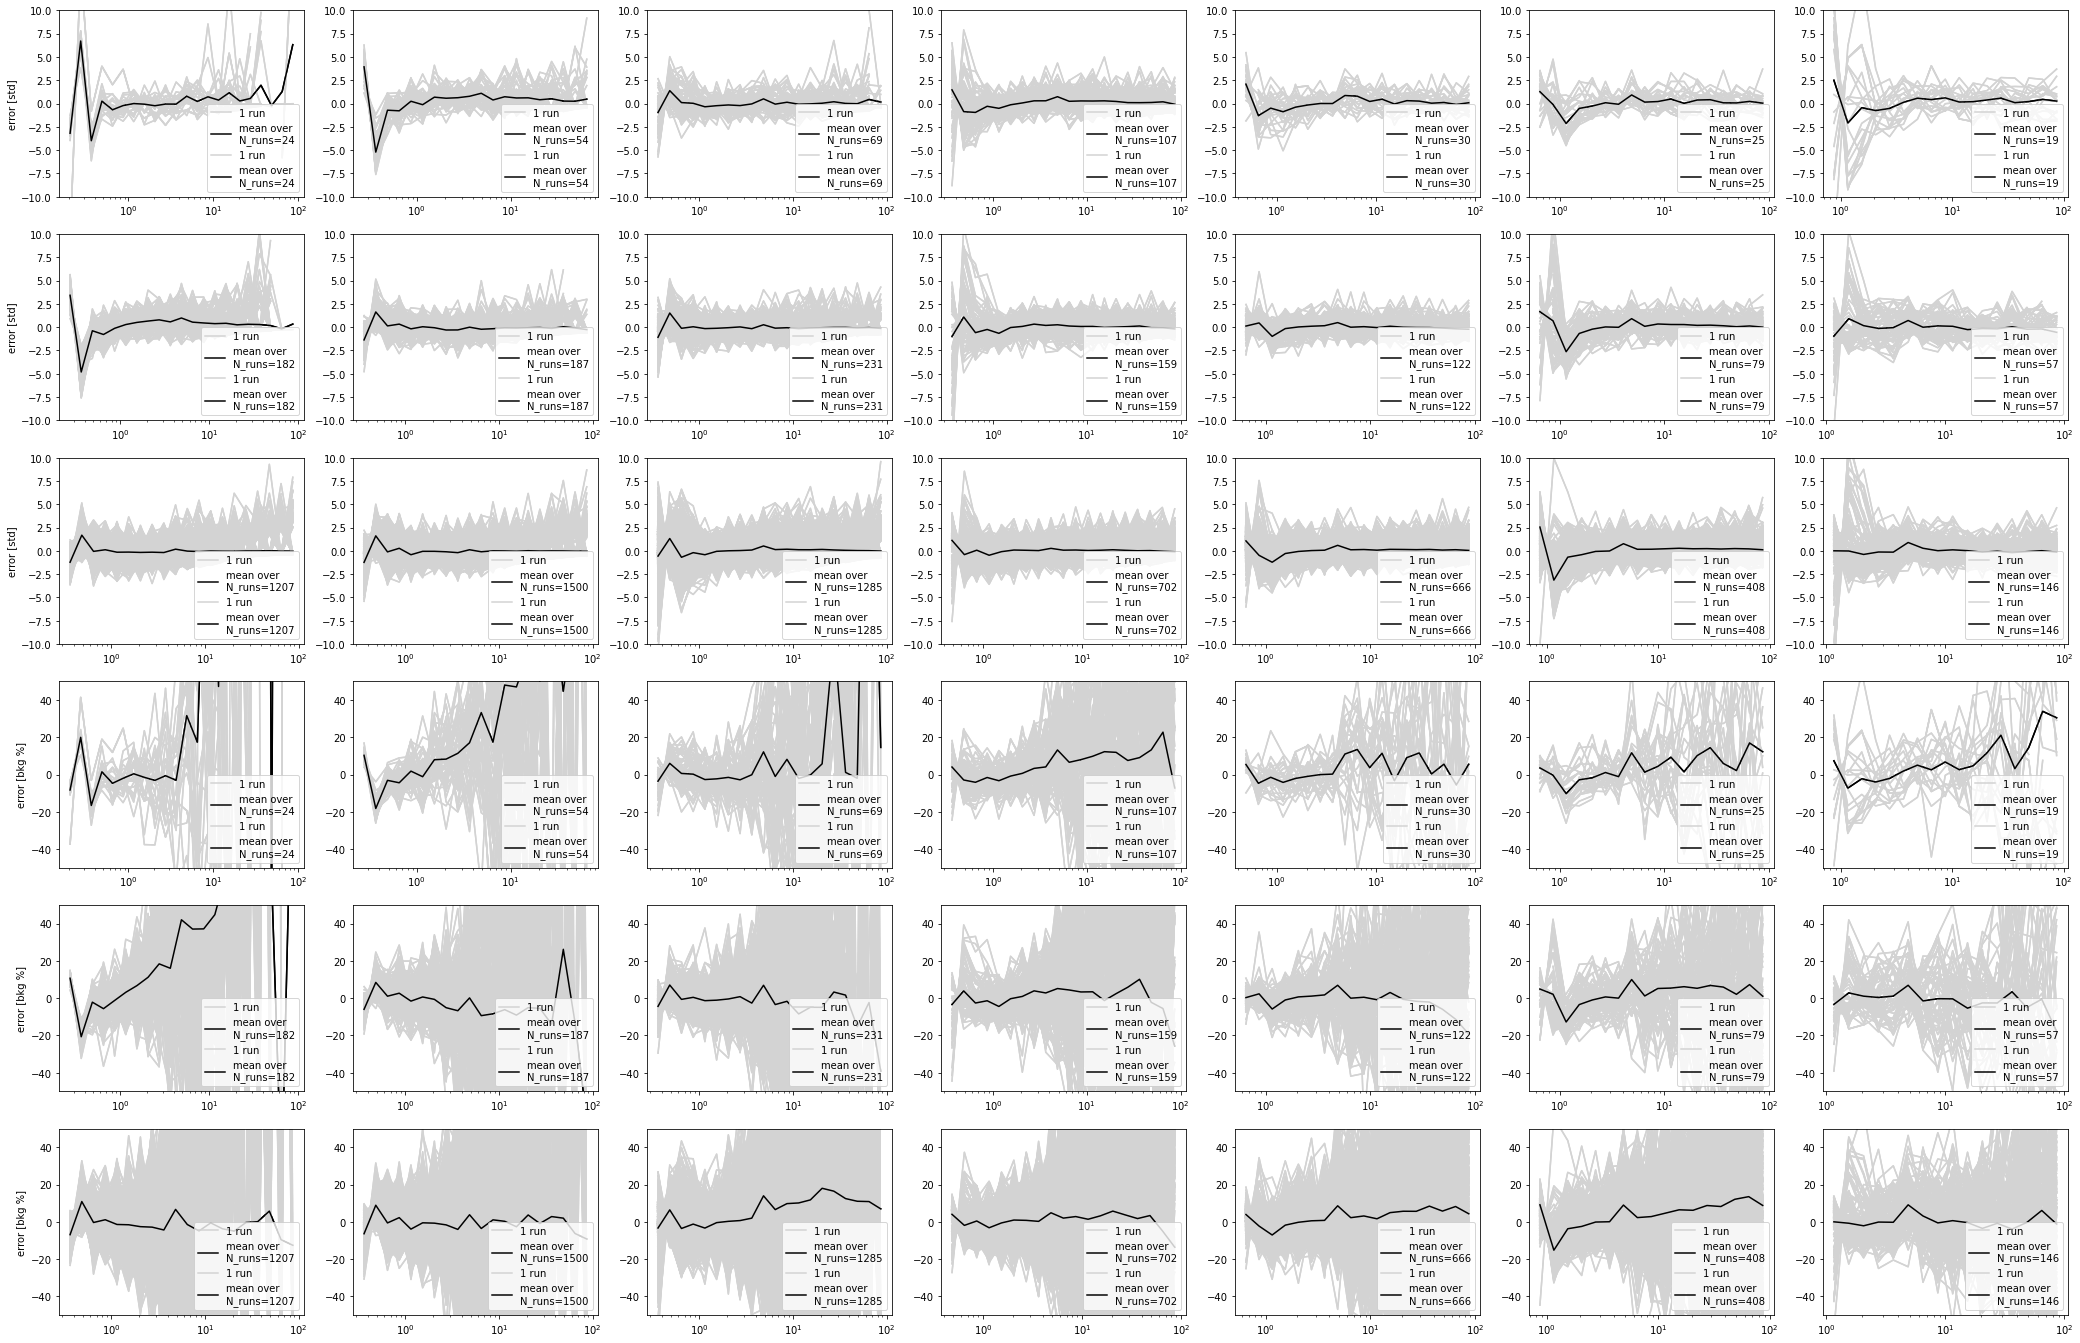

In [46]:
hessera = 'hess1'

edisp, muoneff_flag = call_analysis_type('alternative')
info, error_std, error_percentage = get_results(hessera, edisp, muoneff_flag)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)

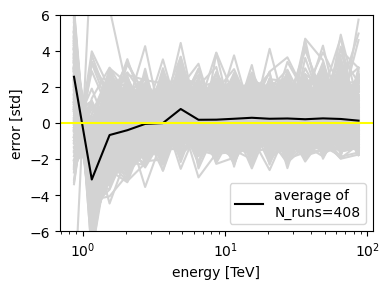

In [55]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

mask_zen = info.T[2] == 5
mask_model = info.T[3] == 2
mask = mask_zen & mask_model
N_est[5][2][0] = np.sum(mask)

res=error_std[mask]
ax.plot(e_center, res.T, color='lightgray');
ax.plot(e_center, np.nanmean(res.T, axis=1), color='black', label=f'average of \nN_runs={np.sum(mask)}');
ax.set_xscale('log')
ax.legend(loc='lower right')
ax.axhline(0, color='yellow')
ax.set_ylim(-6,6)
ax.set_ylabel(f'error [std]')
ax.set_xlabel('energy [TeV]')
plt.tight_layout()
plt.savefig('4.png')

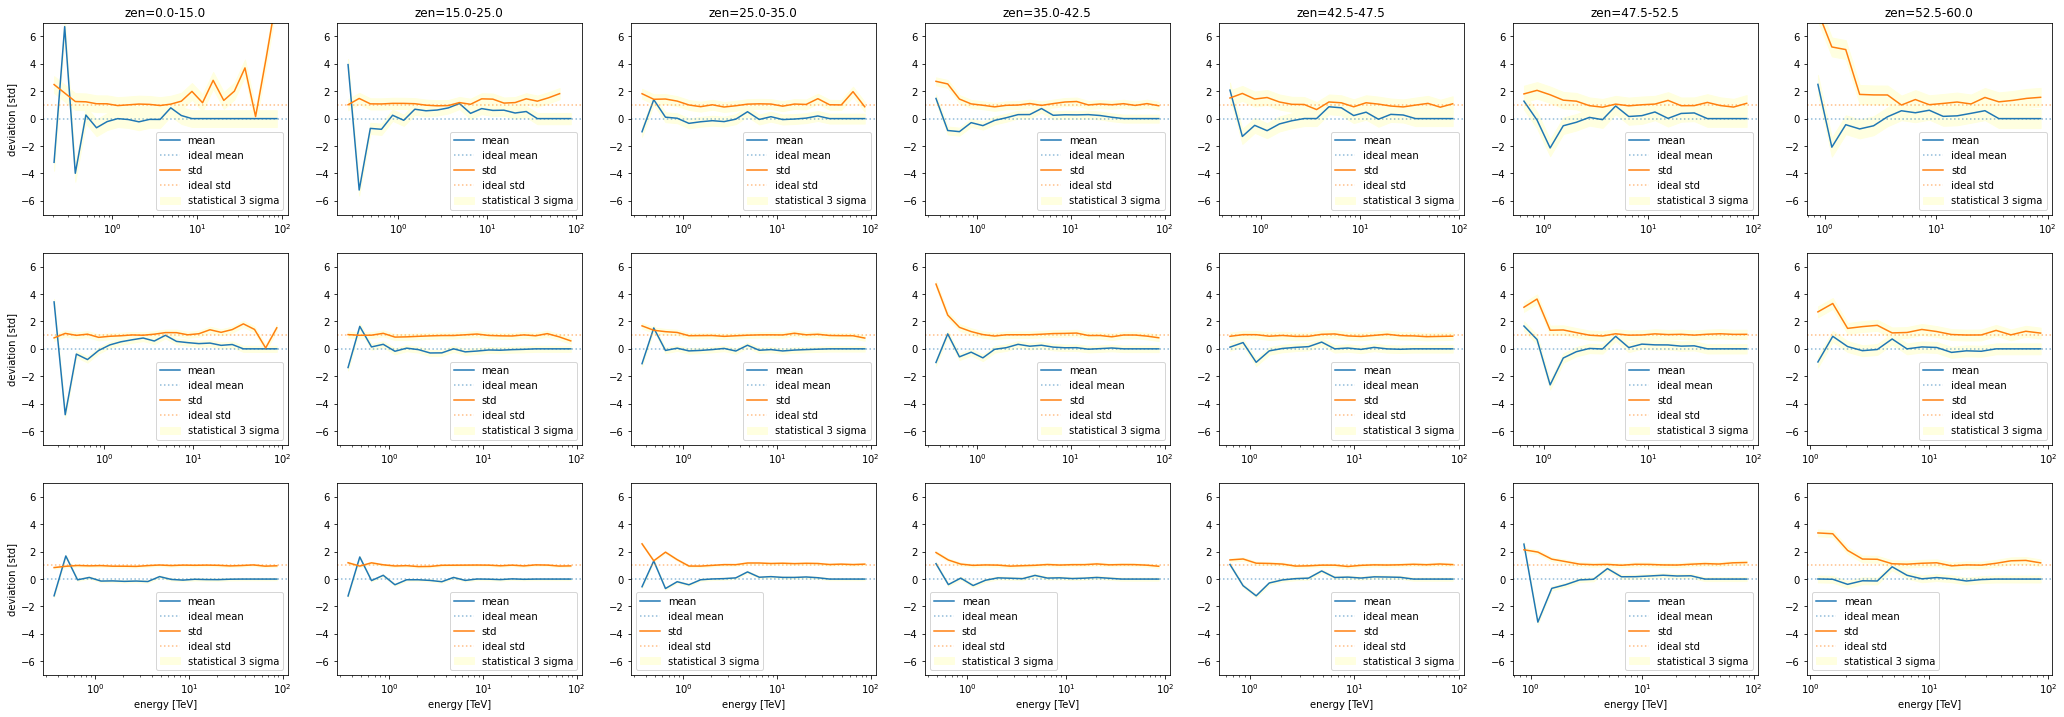

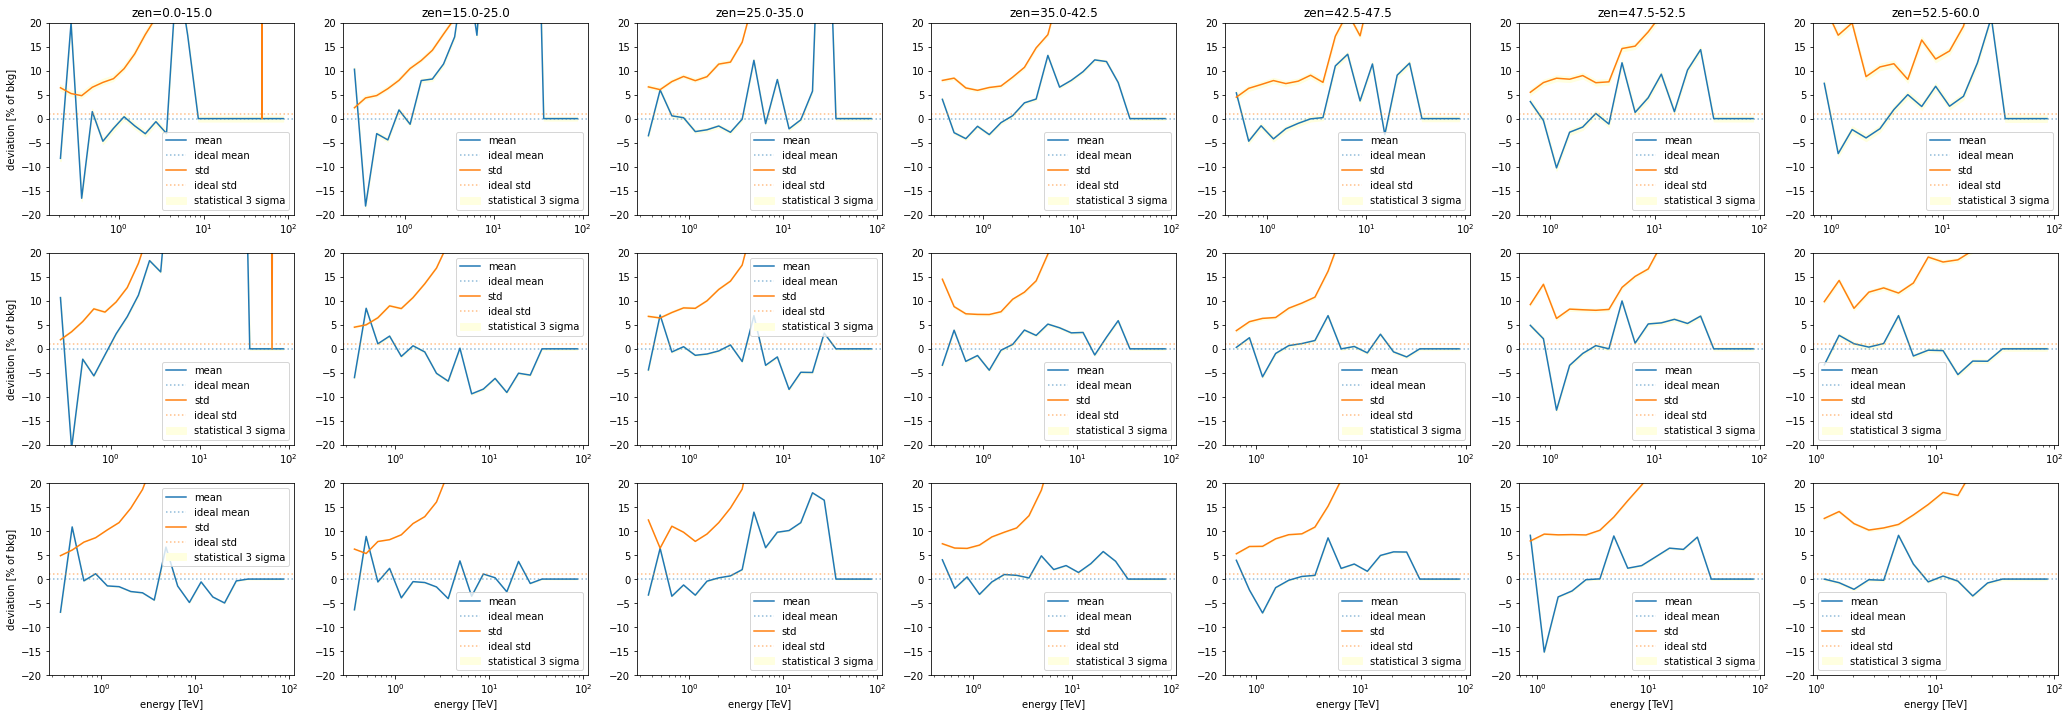

In [58]:
plot_mean_std(N_est, er_est, std_est)

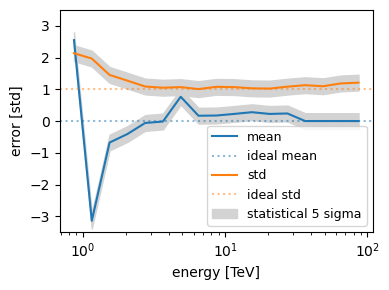

In [71]:
zen=5
model=2
unit=0

fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

N = N_est[zen, model]
mean =er_est[zen, model, unit]
std= std_est[zen, model, unit]
ax.plot(e_center, mean, label='mean')
ax.axhline(0, color='C0', alpha=0.5, ls=':', label='ideal mean')
ax.fill_between(e_center, mean-5/np.sqrt(N), mean+5/np.sqrt(N), color='lightgray', label='statistical 5 sigma')
ax.plot(e_center, std, label='std')
ax.fill_between(e_center, std-5/np.sqrt(N), std+5/np.sqrt(N), color='lightgray')
ax.axhline(1, color='C1', alpha=0.5, ls=':', label='ideal std')
ax.set_xscale('log')
if unit ==0:
    ax.set_ylim(-3.5,3.5)
else:
    ax.set_ylim(-20,20)
ax.set_ylabel(f'error [std]')
ax.set_xlabel('energy [TeV]')
ax.legend(loc='lower right', prop={'size': 9})
plt.tight_layout()
plt.savefig('5.png')

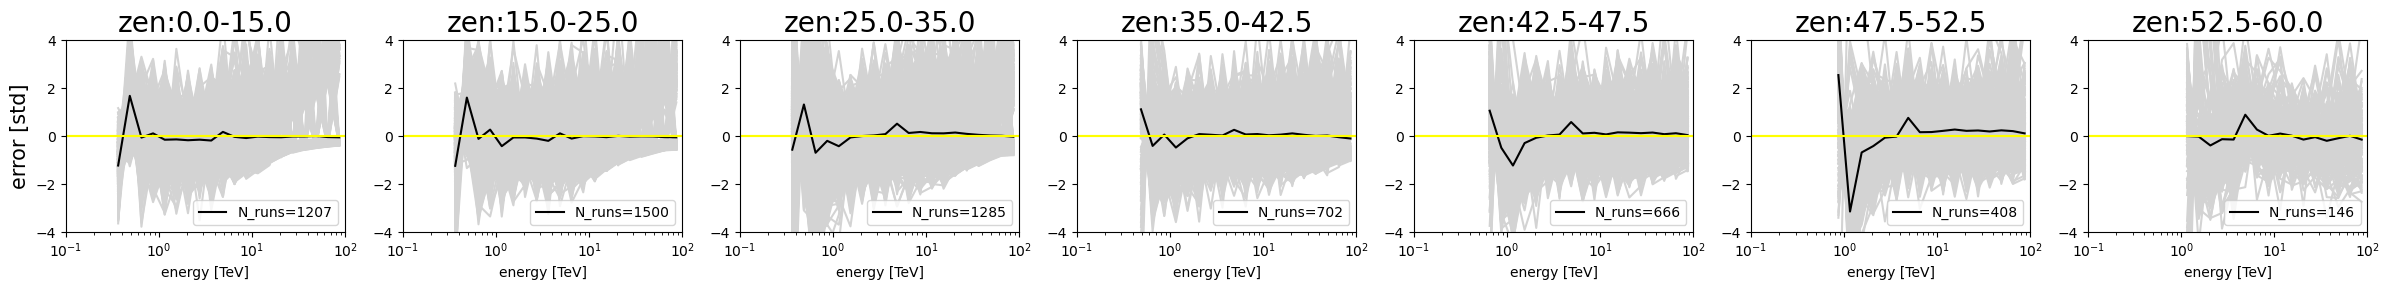

In [85]:
fig, ax = plt.subplots(1, 7, figsize=(24,3), dpi=100)
for zen in range(7):
    mask_zen = info.T[2] == zen
    mask_model = info.T[3] == 2
    mask = mask_zen & mask_model
    N_est[5][2][0] = np.sum(mask)

    res=error_std[mask]
    ax[zen].plot(e_center, res.T, color='lightgray');
    ax[zen].axhline(0, color='yellow')
    ax[zen].plot(e_center, np.nanmean(res.T, axis=1), color='black', label=f'N_runs={np.sum(mask)}');
    ax[zen].set_xscale('log')
    ax[zen].legend(loc='lower right')
    ax[zen].set_xlabel(f'energy [TeV]')
    ax[zen].set_title(f'zen:{zen_bins[zen]}-{zen_bins[zen+1]}', size=20)
    ax[zen].set_ylim(-4,4)
    ax[zen].set_xlim(1e-1,1e2)
    ax[zen].axhline(0, color='yellow')
    if zen==0:
        ax[zen].set_ylabel(f'error [std]', size=15)
    
plt.tight_layout()
plt.savefig('5.png')

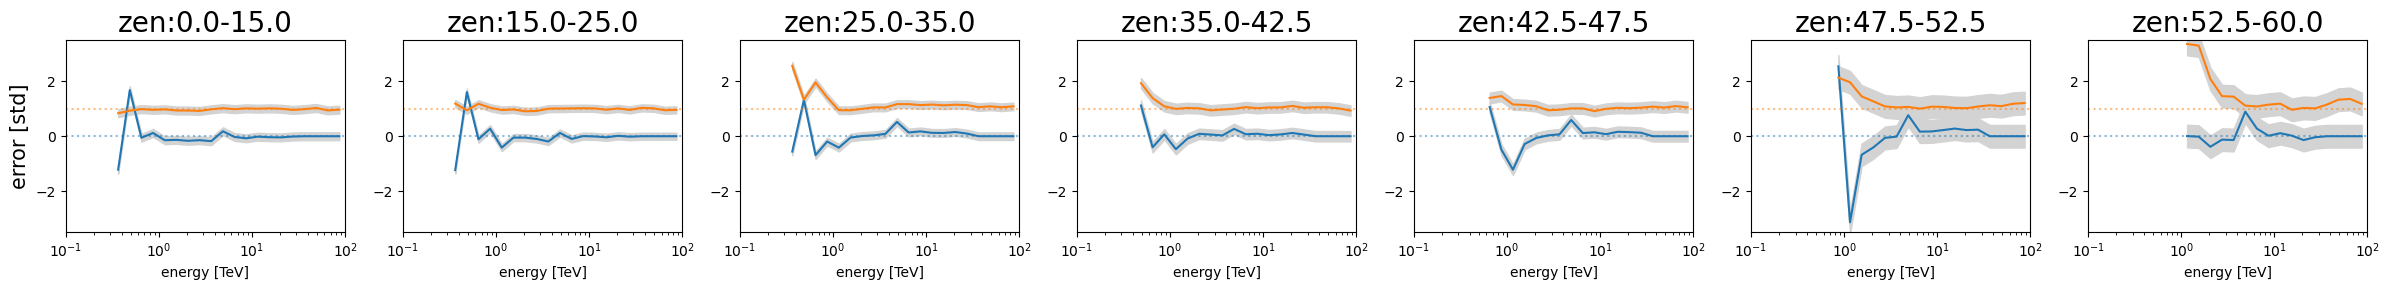

In [87]:
model=2
unit=0

fig, ax = plt.subplots(1, 7, figsize=(24,3), dpi=100)
for zen in range(7):
    N = N_est[zen, model]
    mean =er_est[zen, model, unit]
    std= std_est[zen, model, unit]
    ax[zen].plot(e_center, mean, label='mean')
    ax[zen].axhline(0, color='C0', alpha=0.5, ls=':', label='ideal mean')
    ax[zen].fill_between(e_center, mean-5/np.sqrt(N), mean+5/np.sqrt(N), color='lightgray', label='statistical 5 sigma')
    ax[zen].plot(e_center, std, label='std')
    ax[zen].fill_between(e_center, std-5/np.sqrt(N), std+5/np.sqrt(N), color='lightgray')
    ax[zen].axhline(1, color='C1', alpha=0.5, ls=':', label='ideal std')
    ax[zen].set_xscale('log')
    ax[zen].set_xlim(1e-1,1e2)
    ax[zen].set_title(f'zen:{zen_bins[zen]}-{zen_bins[zen+1]}', size=20)
    if unit ==0:
        ax[zen].set_ylim(-3.5,3.5)
    else:
        ax[zen].set_ylim(-20,20)
    if zen==0:
        ax[zen].set_ylabel(f'error [std]', size=15)
    ax[zen].set_xlabel('energy [TeV]')
    #ax[zen].legend(loc='lower right', prop={'size': 9})
plt.tight_layout()
plt.savefig('6.png')

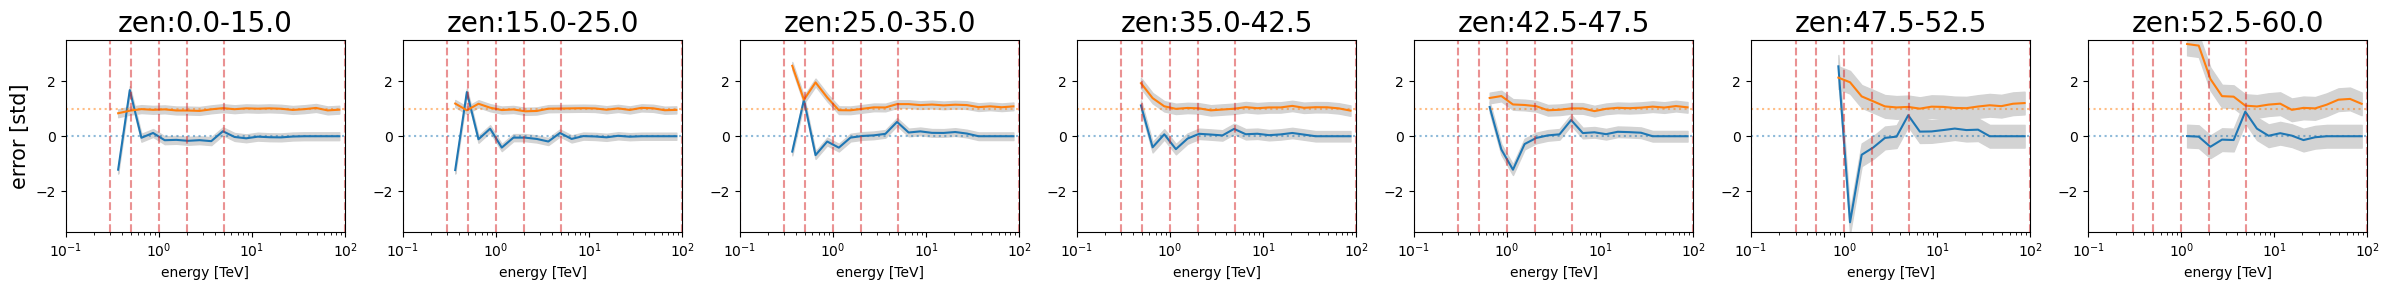

In [92]:
model=2
unit=0

fig, ax = plt.subplots(1, 7, figsize=(24,3), dpi=100)
for zen in range(7):
    N = N_est[zen, model]
    mean =er_est[zen, model, unit]
    std= std_est[zen, model, unit]
    ax[zen].plot(e_center, mean, label='mean')
    ax[zen].axhline(0, color='C0', alpha=0.5, ls=':', label='ideal mean')
    ax[zen].fill_between(e_center, mean-5/np.sqrt(N), mean+5/np.sqrt(N), color='lightgray', label='statistical 5 sigma')
    ax[zen].plot(e_center, std, label='std')
    ax[zen].fill_between(e_center, std-5/np.sqrt(N), std+5/np.sqrt(N), color='lightgray')
    ax[zen].axhline(1, color='C1', alpha=0.5, ls=':', label='ideal std')
    ax[zen].set_xscale('log')
    ax[zen].set_xlim(1e-1,1e2)
    ax[zen].set_title(f'zen:{zen_bins[zen]}-{zen_bins[zen+1]}', size=20)
    if unit ==0:
        ax[zen].set_ylim(-3.5,3.5)
    else:
        ax[zen].set_ylim(-20,20)
    if zen==0:
        ax[zen].set_ylabel(f'error [std]', size=15)
    for bdt in bdt_edges:
        ax[zen].axvline(bdt, color='C3', alpha=0.5, ls='--')
        
    ax[zen].set_xlabel('energy [TeV]')
    #ax[zen].legend(loc='lower right', prop={'size': 9})
plt.tight_layout()
plt.savefig('7.png')

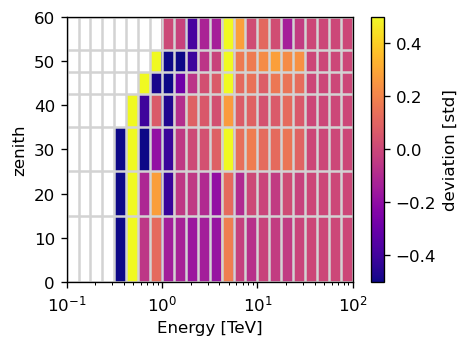

In [98]:
xv, yv = np.meshgrid(zen_bins, energy_bins, indexing='ij')
fig, ax = plt.subplots(1, 1, dpi=120, figsize=(4,3))

i=0
Z = np.zeros((len(zen_bins),len(energy_bins)))
for zen in range(len(zen_bins)-1):
    for e in range(len(energy_bins)-1):
        Z[zen][e] = er_est[zen, 2, i, e]

c = ax.pcolor(yv, xv, Z, cmap='plasma', vmax=0.5, vmin=-0.5)
fig.colorbar(c, ax=ax, label=unit_list[i])
for zen in zen_bins:
    ax.axhline(zen, color='lightgray')
for e in energy_bins:
    ax.axvline(e, color='lightgray')


ax.set_xscale('log')
ax.set_xlabel('Energy [TeV]')
ax.set_ylabel('zenith')
plt.tight_layout()
plt.savefig('8.png')

there are 0/7260 with problems
no runs for zen=0, model=B
no runs for zen=0, model=D
no runs for zen=1, model=B
no runs for zen=1, model=D
no runs for zen=2, model=B
no runs for zen=2, model=D
no runs for zen=3, model=B
no runs for zen=3, model=D
no runs for zen=4, model=B
no runs for zen=4, model=D
no runs for zen=5, model=B
no runs for zen=5, model=D
no runs for zen=6, model=B
no runs for zen=6, model=D


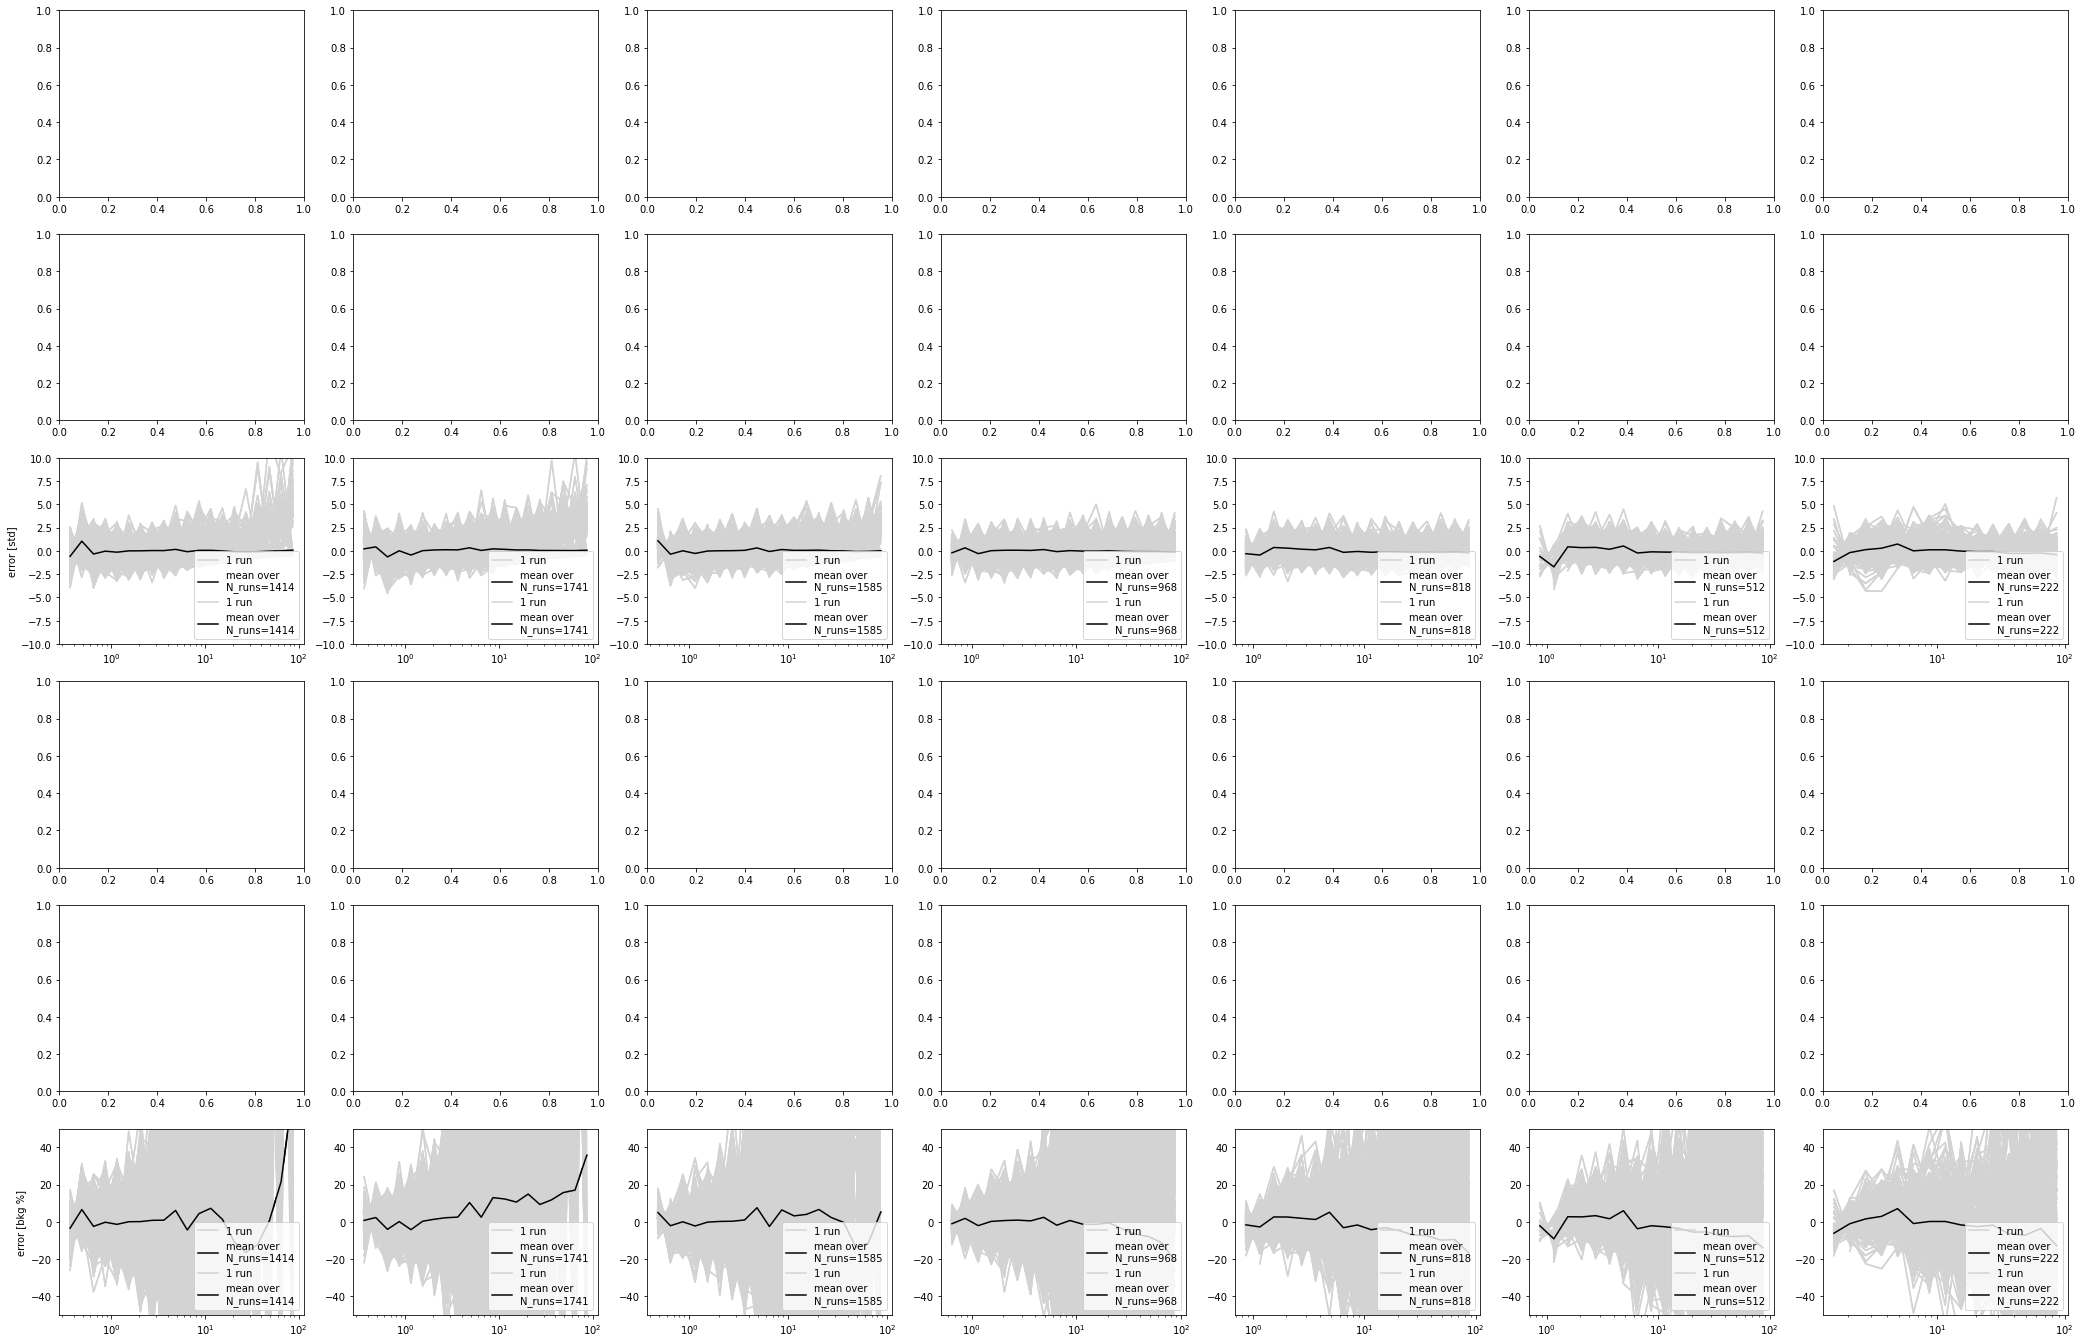

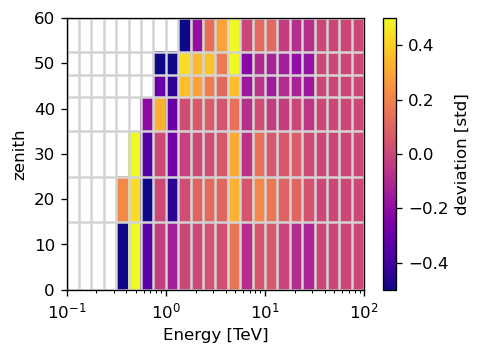

In [99]:
hessera = 'hess1'

edisp, muoneff_flag = call_analysis_type('standard')
info, error_std, error_percentage = get_results(hessera, edisp, muoneff_flag)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)

xv, yv = np.meshgrid(zen_bins, energy_bins, indexing='ij')
fig, ax = plt.subplots(1, 1, dpi=120, figsize=(4,3))

i=0
Z = np.zeros((len(zen_bins),len(energy_bins)))
for zen in range(len(zen_bins)-1):
    for e in range(len(energy_bins)-1):
        Z[zen][e] = er_est[zen, 2, i, e]

c = ax.pcolor(yv, xv, Z, cmap='plasma', vmax=0.5, vmin=-0.5)
fig.colorbar(c, ax=ax, label=unit_list[i])
for zen in zen_bins:
    ax.axhline(zen, color='lightgray')
for e in energy_bins:
    ax.axvline(e, color='lightgray')


ax.set_xscale('log')
ax.set_xlabel('Energy [TeV]')
ax.set_ylabel('zenith')
plt.show()

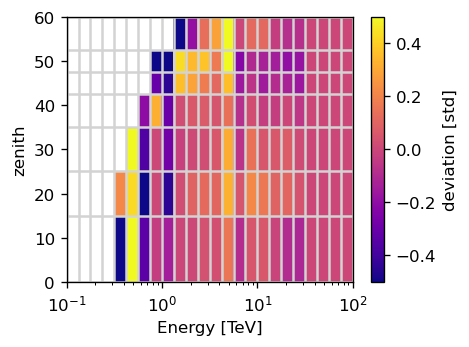

In [100]:
xv, yv = np.meshgrid(zen_bins, energy_bins, indexing='ij')
fig, ax = plt.subplots(1, 1, dpi=120, figsize=(4,3))

i=0
Z = np.zeros((len(zen_bins),len(energy_bins)))
for zen in range(len(zen_bins)-1):
    for e in range(len(energy_bins)-1):
        Z[zen][e] = er_est[zen, 2, i, e]

c = ax.pcolor(yv, xv, Z, cmap='plasma', vmax=0.5, vmin=-0.5)
fig.colorbar(c, ax=ax, label=unit_list[i])
for zen in zen_bins:
    ax.axhline(zen, color='lightgray')
for e in energy_bins:
    ax.axvline(e, color='lightgray')


ax.set_xscale('log')
ax.set_xlabel('Energy [TeV]')
ax.set_ylabel('zenith')
plt.tight_layout()
plt.savefig('9.png')

In [ ]:
hessera = 'hess1'

edisp, muoneff_flag = call_analysis_type('standard')
info, error_std, error_percentage = get_results(hessera, edisp, muoneff_flag)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)
plot_lookup_table(er_est)

In [ ]:
hessera = 'hess1'

edisp, muoneff_flag = call_analysis_type('standard')
info, error_std, error_percentage = get_results(hessera, edisp, muoneff_flag)
N_est, er_est, std_est = calculate_error(info, error_std, error_percentage)
plot_lookup_table(er_est)

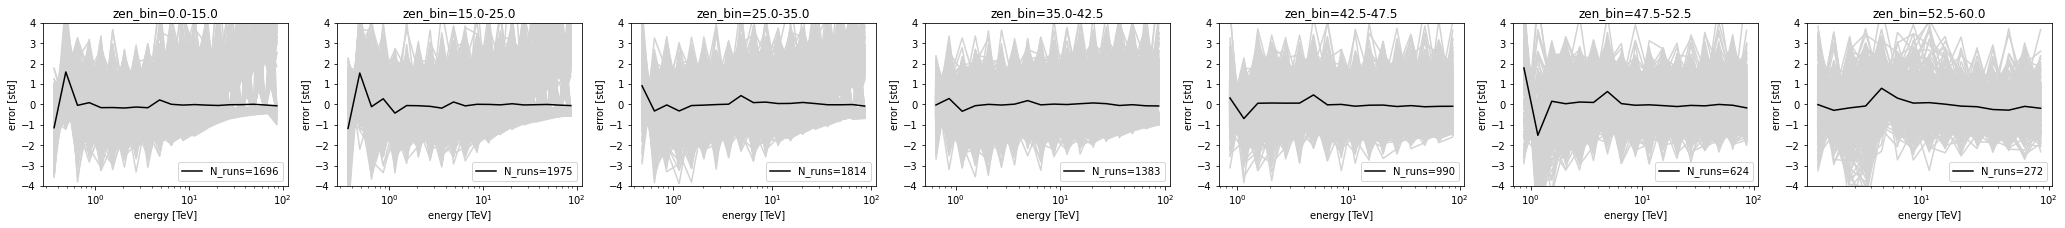

In [71]:
fig, ax = plt.subplots(1, 7, figsize=(3*12,3))
for zen in range(7):
    mask_zen = info.T[2] == zen
    mask_model = info.T[3] == 2
    mask = mask_zen & mask_model
    N_est[5][2][0] = np.sum(mask)

    res=error_std[mask]
    ax[zen].plot(e_center, res.T, color='lightgray');
    ax[zen].plot(e_center, np.nanmean(res.T, axis=1), color='black', label=f'N_runs={np.sum(mask)}');
    ax[zen].set_xscale('log')
    ax[zen].legend(loc='lower right')
    ax[zen].set_ylabel(f'error [std]')
    ax[zen].set_xlabel(f'energy [TeV]')
    ax[zen].set_title(f'zen_bin={zen_bins[zen]}-{zen_bins[zen+1]}')
    ax[zen].set_ylim(-4,4)

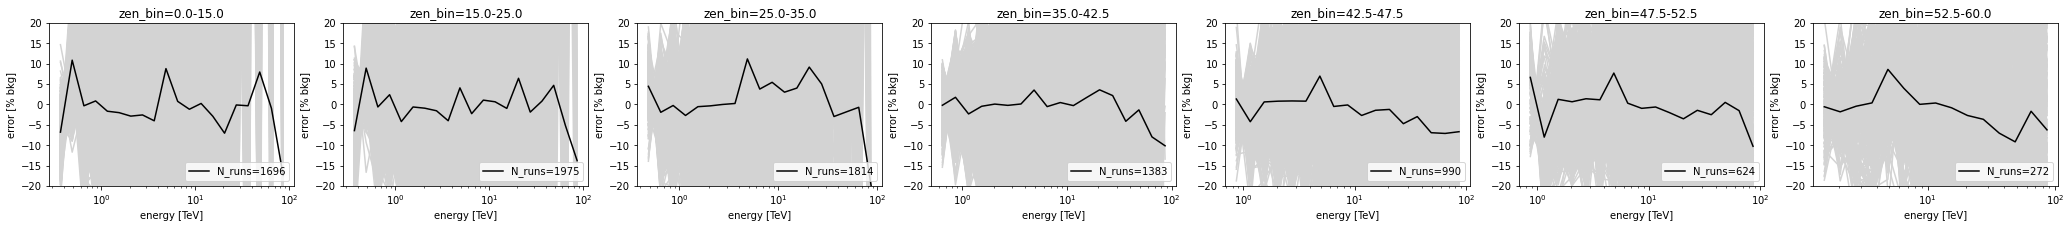

In [72]:
fig, ax = plt.subplots(1, 7, figsize=(3*12,3))
for zen in range(7):
    mask_zen = info.T[2] == zen
    mask_model = info.T[3] == 2
    mask = mask_zen & mask_model
    N_est[5][2][0] = np.sum(mask)

    res=error_percentage[mask]
    ax[zen].plot(e_center, res.T, color='lightgray');
    ax[zen].plot(e_center, np.nanmean(res.T, axis=1), color='black', label=f'N_runs={np.sum(mask)}');
    ax[zen].set_xscale('log')
    ax[zen].legend(loc='lower right')
    ax[zen].set_ylabel(f'error [% bkg]')
    ax[zen].set_xlabel(f'energy [TeV]')
    ax[zen].set_title(f'zen_bin={zen_bins[zen]}-{zen_bins[zen+1]}')
    ax[zen].set_ylim(-20,20)

<Figure size 1440x1440 with 0 Axes>

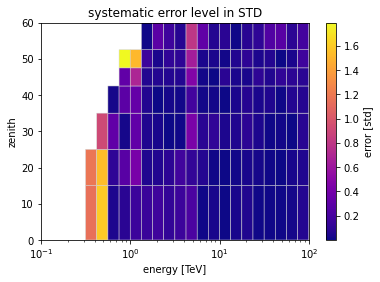

<Figure size 1440x1440 with 0 Axes>

In [114]:
xedges=energy_bins
yedges=zen_bins

X,Y = np.meshgrid(xedges, yedges)
plt.pcolor(X, Y, abs(er_est[:, 2, 0, :]), edgecolors='lightgray', linewidths=0.5, cmap='plasma')
cbar=plt.colorbar()
cbar.set_label('error [std]')
plt.xscale('log')
plt.ylabel('zenith')
plt.xlabel('energy [TeV]')
plt.title('systematic error level in STD')
plt.figure(figsize=(20,20))

<Figure size 1440x1440 with 0 Axes>

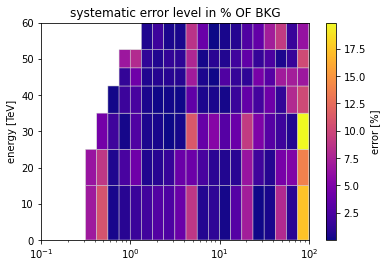

<Figure size 1440x1440 with 0 Axes>

In [115]:
xedges=energy_bins
yedges=zen_bins

X,Y = np.meshgrid(xedges, yedges)
plt.pcolor(X, Y, abs(er_est[:, 2, 1, :]), edgecolors='lightgray', linewidths=0.5, cmap='plasma')
cbar=plt.colorbar()
cbar.set_label('error [%]')
plt.xscale('log')
plt.ylabel('zenith')
plt.ylabel('energy [TeV]')
plt.title('systematic error level in % OF BKG')
plt.figure(figsize=(20,20))